# Head Models and Coordinate Reference Systems (CRS)

In [1]:
import pyvista as pv
#pv.set_jupyter_backend('server')
pv.set_jupyter_backend('static')

import os
import xarray as xr

import cedalion
import cedalion.io
import cedalion.plots
import cedalion.datasets
import cedalion.imagereco.forward_model as fw

xr.set_options(display_expand_data=False);

## Loading the ICBM-152 head model

- the `TwoSurfaceHeadModel` holds the segmented MRT image and derived cortex and scalp surfaces
- we provide functionality to derive these surfaces from the masks or to load them from files

In [2]:
# load pathes to segmentation data for the icbm-152 atlas
SEG_DATADIR, mask_files, landmarks_file = cedalion.datasets.get_icbm152_segmentation()

# create forward model class for icbm152 atlas
head_icbm152 = fw.TwoSurfaceHeadModel.from_surfaces(
    segmentation_dir=SEG_DATADIR,
    mask_files=mask_files,
    brain_surface_file=os.path.join(SEG_DATADIR, "mask_brain.obj"),
    landmarks_ras_file=landmarks_file,
    brain_face_count=None,
    scalp_face_count=None,
)

## Visualization

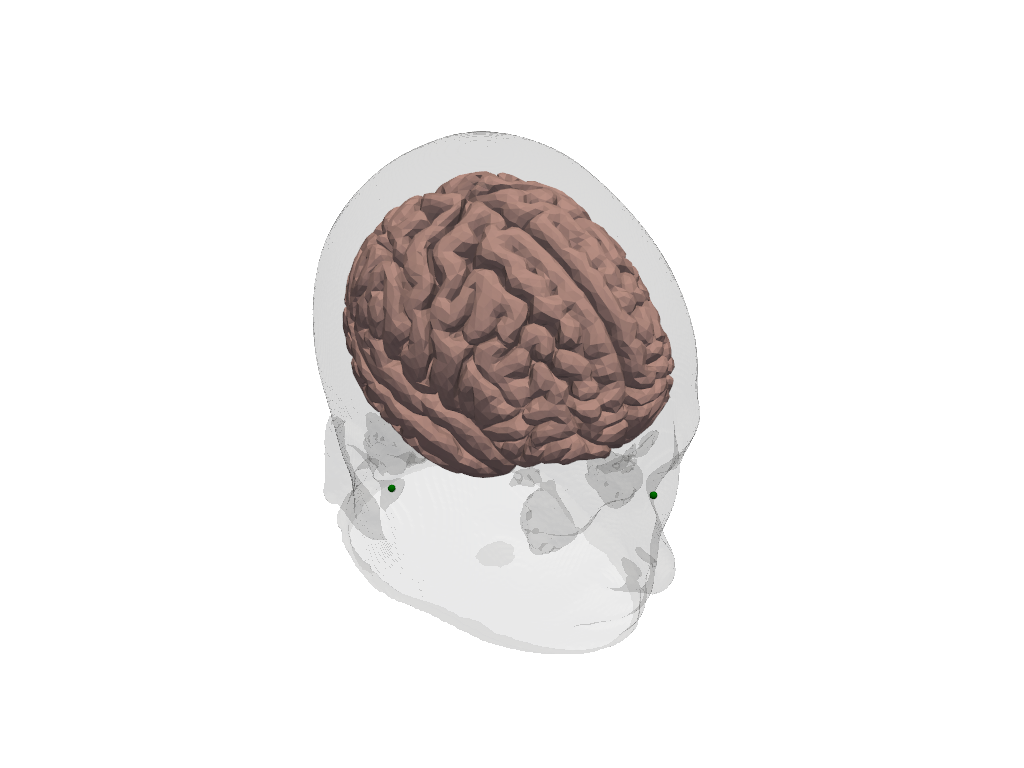

In [3]:
plt = pv.Plotter()
cedalion.plots.plot_surface(plt, head_icbm152.brain, color="#d3a6a1")
cedalion.plots.plot_surface(plt, head_icbm152.scalp, opacity=.1)
cedalion.plots.plot_labeled_points(plt, head_icbm152.landmarks, show_labels=True)
plt.show()

## Segmentation masks

The head model comprises masks for different tissue types: CSF, Gray Matter, White Matter, Scalp and Skull

In [4]:
head_icbm152.segmentation_masks

<xarray.DataArray (segmentation_type: 5, i: 193, j: 239, k: 263)> Size: 61MB
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
Coordinates:
  * segmentation_type  (segmentation_type) <U5 100B 'csf' 'gm' ... 'skull' 'wm'
Dimensions without coordinates: i, j, k

## Coordinate System

- we need to distinguish several coordinate systems: voxel space, scanner space, subject space, ...
- geometric data types carry information about which crs they use
- transformations between coordinate systems through affine transformations


The head model is loaded in voxel space ('ijk')

In [5]:
head_icbm152.crs

'ijk'

The head model contains initial landmarks ('Nz', 'Iz', 'LPA' and 'RPA') stored as a LabeledPointCloud.
The crs is stored as the name of the second dimension, easily retrievable through the `.points`-accessor 

In [6]:
display(head_icbm152.landmarks)
display(head_icbm152.landmarks.points.crs)

Magnitude,[[96.0 218.10000000000156 108.00000000000182] [95.99999999999902 18.899999999999395 100.99999999999926] [15.899999999999622 120.0000000000005 102.00000000000054] [178.09999999999948 120.00000000000054 103.0000000000006]]
Units,dimensionless


'ijk'

Triangulated surface meshes of the scalp and brain:

In [7]:
display(head_icbm152.brain)
display(head_icbm152.scalp)

TrimeshSurface(mesh=<trimesh.Trimesh(vertices.shape=(15002, 3), faces.shape=(29992, 3))>, crs='ijk', units=<Unit('dimensionless')>)

TrimeshSurface(mesh=<trimesh.Trimesh(vertices.shape=(255950, 3), faces.shape=(511242, 3))>, crs='ijk', units=<Unit('dimensionless')>)

In [8]:
head_icbm152.t_ijk2ras # transformation from voxel to subject (RAS) space

Magnitude,[[1.0 0.0 0.0 -96.0] [0.0 1.0 0.0 -132.0] [0.0 0.0 1.0 -148.0] [0.0 0.0 0.0 1.0]]
Units,millimeter


Change to subject (RAS) space by applying an affine transformation on the head model.
This transforms all components.

Here, the subject space is called 'aligned' (the label is derived from information in the mask's nifti file)

The scanner space also uses physical units whereas coordinates in voxel space are dimensionless.

In [9]:
trafo = head_icbm152.t_ijk2ras

head_icbm152_ras = head_icbm152.apply_transform(trafo)

display(head_icbm152_ras.crs)
display(head_icbm152_ras.landmarks.points.crs)
display(head_icbm152_ras.brain.crs)

display(head_icbm152.landmarks.pint.units)
display(head_icbm152_ras.landmarks.pint.units)

'aligned'

'aligned'

'aligned'

<Unit('dimensionless')>

<Unit('millimeter')>